<a href="https://colab.research.google.com/github/t1nh233/predict_vnindex_stacked_lstm/blob/main/lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas_ta
import pandas as pd
import pandas_ta as ta
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

## **1. Dữ liệu và tiền xử lý dữ liệu**
### **1.1. Thu thập và làm sạch dữ liệu**
Dữ liệu lịch sử của chỉ số VN-Index được thu thập từ nền tảng [Investing.com](https://www.investing.com/indices/vn-historical-data) trong giai đoạn từ **12/09/2010 đến 12/09/2025**. Tập dữ liệu thô bao gồm các trường thông tin cơ bản: **Giá mở cửa (Open)**, **Giá cao nhất (High)**, **Giá thấp nhất (Low)**, **Giá đóng cửa (Price/Close)**, **Khối lượng giao dịch (Vol)** và **Phần trăm thay đổi (Change)**.

Để đảm bảo được tính nhất quán và phú hợp cho mô hình huấn luyện, quá trình làm sạch dữ liệu được thực hiện qua các bước sau:
1. **Định dạng thời gian**: Chuyển đổi cột **Date** sang định dạng `datetime` chuẩn và thiết lập làm chỉ số (Index) cho chuỗi thời gian.
2. **Chuẩn hóa định dạng số**: Xử lý dấu phân cách thập phân/ hàng nghìn (loại bỏ đấu phẩy gây nhiễu trong dữ liệu gốc).
3. **Chuyển đổi đơn vị đo lường**: Quy đổi các giá trị Khối lượng (Volume) và Phần trăm thay đổi (Change) từ dạng ký tự viết tắt về dạng số thực nguyên bản.
4. **Ép kiểu dữ liệu**: Toàn bộ các đặc trưng số được được chuyển đổi thống nhất về kiểu dữ liệu `float64` để phục vụ việc tính toán sau này.


In [3]:
## Doc du lieu
url = "https://raw.githubusercontent.com/t1nh233/predict_vnindex_stacked_lstm/refs/heads/main/vn_index_historical_data_9_12.csv"
vnindex = pd.read_csv(url)
vnindex.head()


## Xu ly du lieu thoi gian va dua Date thanh index
vnindex['Date'] = pd.to_datetime(vnindex['Date'], format='%m/%d/%Y')
vnindex = vnindex.sort_values(by='Date')
vnindex.set_index('Date', inplace=True)


## Chuyen doi ve dung dinh dang va dung don vi
columns_convert_to_float = ["Price", "Open", "High", "Low"]
for column in columns_convert_to_float:
    vnindex[column] = vnindex[column].str.replace(",", "").astype(float)


### Ham ho tro chuyen doi Volume
def convert_volume(vol_str):
    multiplier_dict = {"K": 1000, "M": 1000000, "B": 1000000000}

    if not isinstance(vol_str, str):
        return vol_str

    vol_str = vol_str.upper().strip()
    last_char = vol_str[-1]

    if last_char in multiplier_dict.keys():
        multiplier_val = multiplier_dict[last_char]
        number_part = vol_str[:-1]
    else:
        multiplier_val = 1
        number_part = vol_str

    try:
        number = float(number_part.replace(',', ''))
    except ValueError:
        return np.nan

    return number * multiplier_val


### Ham ho tro chuyen doi Change
def convert_change(change_str):
    if not isinstance(change_str, str):
        return change_str

    if change_str.endswith('%'):
        number_part = change_str[:-1]
    else:
        number_part = change_str

    try:
        number = float(number_part.replace(',', ''))
    except ValueError:
        return np.nan

    return number / 100.0


## Bien doi Volume va Change
vnindex['Vol.'] = vnindex['Vol.'].apply(convert_volume)
vnindex['Change %'] = vnindex['Change %'].apply(convert_change)


## Doi ten cot ve dang chuan hon
vnindex.rename(columns={'Price': 'Close', 'Vol.': 'Volume', 'Change %': 'Change'}, inplace=True)


## Them cot label vao cuoi cua moi ngay
vnindex['label'] = vnindex['Close'].shift(-1)

##Lay log cua Volume
vnindex['Volume'] = np.log1p(vnindex['Volume'])

# ## Kiem tra lai du lieu da xu ly
print(vnindex.info())
print(vnindex.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3743 entries, 2010-12-09 to 2025-12-09
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3743 non-null   float64
 1   Open    3743 non-null   float64
 2   High    3743 non-null   float64
 3   Low     3743 non-null   float64
 4   Volume  3743 non-null   float64
 5   Change  3743 non-null   float64
 6   label   3742 non-null   float64
dtypes: float64(7)
memory usage: 233.9 KB
None
             Close    Open    High     Low     Volume  Change   label
Date                                                                 
2010-12-09  460.45  450.59  460.79  450.16  11.011572  0.0168  473.06
2010-12-10  473.06  464.81  473.06  462.39  11.452230  0.0274  490.22
2010-12-13  490.22  485.82  490.30  485.73  11.314243  0.0363  489.65
2010-12-14  489.65  493.72  496.42  480.64  11.812667 -0.0012  493.47
2010-12-15  493.47  492.80  497.09  491.51  11.468775  0.0078  480.21


### **1.2. Trích xuất đặc trưng kỹ thuật (Feature Extraction)**
Mặc dù dữ liệu giá gốc (OHLCV) cung cấp thông tin nền tảng, theo các nghiên cứu nhận định rằng việc chỉ sử dụng giá đóng của thô (Raw Close Price) là chưa đủ để mô hình nắm bắt được các mẫu hình phức tạp của thị trường. Dựa trên các các công trinh nghiên cứu liên quan đến dự báo chuỗi thời gian tài chính, nhóm tiến hành trích xuất thêm các chỉ bảo phân tích kỹ thuật làm đầu vào bổ sung. Các đặc trưng này được phân loại thành 3 nhóm chính:
#### **1.2.1. Nhóm chỉ báo Xu hướng (Trend Indicators)**
Nhóm chỉ báo này giúp khử nhiễu biến động giá ngẫu nhiên và xác định hướng di chuyển chính của thị trường:
- **SMA (Simple Moving Average - Đường trung bình động đơn giản)**: Được tính bằng trung bình cộng giá đóng của trong **chu kỳ 20 ngày (tương đương 1 tháng giao dịch)**. Việc lựa chọn `SMA(20)` giúp làm mượt dữ liệu và xác định được xu hướng ngắn hạn.
- **EMA (Exponential Moving Average - Đường trung bình động lũy thừa)**: Khác với SMA, EMA đặt trọng số lớn hơn vào các dữ liệu giá gần nhất nhằm giảm độ trễ (lag) và phản ứng nhạy hơn với các biến động hiện tại. Nhóm sử dụng EMA với **chu kỳ 50 ngày** để nắm bắt xu hướng trung hạn và đóng vai trò như ngưỡng hỗ trợ/ kháng cự động.

In [4]:
# SMA(20)
vnindex['SMA'] = ta.sma(vnindex['Close'], length=20)

# EMA(50)
vnindex['EMA'] = ta.ema(vnindex['Close'], length=50)

#### **1.2.2. Nhóm chỉ báo Động lượng và Biến động (Momentum & Volatility Indicators)**
Các chỉ báo này cung cấp thông tin về sức mạnh của xu hướng và độ rủi ro của thị trường:
- **RSI (Relative Strength Index - Chỉ số sức mạnh tương đối)**: Đo lường tốc độ và mức độ thay đổi giá để xác định các vùng quá mua hoặc quá bán. Tham số chu kỳ được thiết lập là **14 ngày** theo khuyến nghị chuẩn của tác giả **J. Welles Wilder**.
- **MACD (Moving Average Convergence Divergence)**: Phân tích mối quan hệ giữa hai đường trung bình động (EMA) để phát hiện sự thay đổi trong sức mạnh, hướng và động lượng của thị trường. Bộ tham số tiêu chuẩn **(12, 26, 9)** được áp dụng dựa trên đề xuất của **Gerald Appel**.
- **BB (Bollinger Bands - Dải Bollinger)**: Đo lường độ biến động của thị trường. Chỉ báo được cấu thành từ một đường trung bình động (SMA 20) và hai dải biên trên/dưới các nhau 2 độ lệch chuẩn (std = 2.0). Đây là thiết lập tối ưu để bao quát khoảng 95% biến động giá thông thường.

In [5]:
# RSI (14)
vnindex['RSI'] = ta.rsi(vnindex['Close'], length=14)


# MACD(12, 26, 9)
vnindex['MACD'] = ta.macd(vnindex['Close'])['MACD_12_26_9']
vnindex['MACD_Signal'] = ta.macd(vnindex['Close'])['MACDs_12_26_9']
vnindex['MACD_Hist'] = ta.macd(vnindex['Close'])['MACDh_12_26_9']


# BB(20, 2.0)
bb_values = ta.bbands(vnindex['Close'], length=20, std=2.0)
vnindex['BB_Width'] = ta.bbands(vnindex['Close'], length=20, std=2.0)['BBB_20_2.0_2.0']
vnindex['BB_Percentage'] = ta.bbands(vnindex['Close'], length=20, std=2.0)['BBP_20_2.0_2.0']

### **1.3. Cơ sở lựa chọn đặc trưng đầu vào**
Sau khi tính toán các đặc trưng kỹ thuật xong, việc lựa chọn những đặc trưng nào để huấn luyện cũng là một bước quan trọng. Cụ thể các nhóm đặc trưng được lựa chọn vì những lý do sau:
1. **Nhóm Dữ liệu gốc (Raw Data)**
   - **Close (Giá đóng cửa)**: Là đặc trưng không thể thiếu, đây là nền tảng để tính toán mọi chỉ báo khác.
   - **Volume (Khối lượng)**: Volume là đậc trưng xác nhận sức mạnh của xu hướng. Việc đưa Volume vào giúp mô hình phân biệt được đâu là tính hiệu thật, đâu là tín hiệu giả (giá tăng nhưng volume thấp → tín hiệu giả).
2. **Nhóm Xu hướng (Trend)**
   - Dữ liệu giá theo ngày thường bị nhiễu. **SMA và EMA** giúp làm mượt dữ liệu, giúp mô hình nhận diện được hướng đi chủ đạo thay vì bị mắc kẹt ở các biến động nhỏ lẻ trong ngày.
3. **Nhóm Động lượng (Momentum)**
   - **RSI**: Giúp mô hình phát hiện các điểm đảo chiều tiềm năng thông qua vùng Quá mua/Quá bán. Quan trọng hơn, RSI giúp phát hiện tín hiệu phân kỳ.
   - **MACD_Hist**: Thay vì dùng đường MACD, việc sử dụng Histogram giúp mô hình đo lường gia tốc của xu hướng. Histogram đổi màu hoặc tiến về 0 là dấu hiệu cho thấy xu hướng hiện tại đang yếu đi.
4. **Nhóm Biến động (Volatility)**
   - **BB_Width**: Đại diện cho mức độ biến động của thị trường. Khi **BB_Width** co lại báo hiệu thị trường sắp có biến động bùng nổ. Đặc trưng này giúp mô hình chuẩn bị cho các đợt biến động mạnh sắp xảy ra.
   - **BB_Percentage**: Là đặc trưng đã được chuẩn hóa, cho biết vị trí tương đối của giá so với hai dải băng, cho biết vị trí tương đối của giá so với hai dải băng. Giá trị này có tính hữu ích cao vì nó đã được chuẩn hóa vị trí giá về một phạm vi tương đối, giúp mô hình dễ học hơn so với giá trị tuyệt đối.



In [6]:
# Xoa cac dong NaN(co it nhat 1 gia tri Nan trong hang = xoa)
vnindex_clean = vnindex.dropna()


## Chon va sap xep lai cac features
feature_columns = ['Close', 'Volume', 'RSI', 'SMA', 'EMA', 'MACD_Hist', 'BB_Width', 'BB_Percentage']
target_column = 'label'

all_data_cleaned = vnindex_clean.columns.tolist()
train_feature = feature_columns + [target_column]
train_feature_data = vnindex_clean[train_feature].copy()
train_feature_cols = train_feature_data.columns.tolist()
target_index = train_feature_cols.index(target_column)

###**1.4. Chia tập dữ liệu (Train/Validation/Test Split)**
Để đánh giá hiệu quả của mô hình và ngăn chặn hiện tượng quá khớp (Overfitting), tập dữ liệu sau khi tiền xử lý được chia thành 3 phần độc lập: **Tập huấn luyện (Training set)**, **Tập kiểm định (Validation set)** và **Tập kiểm tra (Test set)** theo **tỷ lệ 70% - 20% - 10%**.

Với tổng thời gian thu tập 15 năm (2010 - 2025), tỷ lệ **10%** cho **tập kiểm tra** tương đương khoảng 1.5 năm dữ liệu giao dịch. Đây là khoảng thời gian đủ lớn để bao quát các biến động thị trường, đảm bảo kết quả đánh giá mang tính khách quan và tin cậy.

**Lưu ý**: Khác với các bài toán hồi quy thông thường, dữ liệu chứng khoán có tính phụ thuộc thời gian, do đó phương pháp phân chia ngẫu nhiên (Random Shuffle) không được áp dụng để tránh hiện tượng rò rỉ dữ liệu tương lai.

In [7]:
## Chia tap du lieu thanh Train, Valid va Test

total_samples = len(train_feature_data)
train_set_size = int(total_samples * 0.7)
valid_set_size = int(total_samples * 0.2)
test_set_size = total_samples - train_set_size - valid_set_size

train_size = int(len(train_feature_data) * 0.7)
val_size = int(len(train_feature_data) * 0.15)
test_size = len(train_feature_data) - train_set_size - valid_set_size

train_data = train_feature_data[:train_set_size]
val_data = train_feature_data[train_set_size : train_set_size + valid_set_size]
test_data = train_feature_data[train_set_size + valid_set_size:]

### **1.5. Chuẩn hóa dữ liệu (Normalization)**
Trong mô hình mạng neural hồi quy (RNN) nói chung và LSTM nói riêng, bước chuẩn hóa dữ liệu là bước bắt buộc trong phần tiền xử lý dữ liệu vì hai lý do chính:
1. **Độ hội tụ**: Dữ liệu tài chính thường có sự chếnh lệch lớn về độ lớn (ví dụ: giá trị khối lượng giao dịch có thể lên tới vào trăm ngàn, trong khi tỷ lệ thay đổi giá chỉ là số thập phân nhỏ). Nếu không chuẩn hóa, Gradient Descent sẽ mất rất nhiều thời gian để hội tụ hoặc bị kẹt ở điểm cực tiểu địa phương.
2. **Đặc tính của hàm kích hoạt**: Vì các cổng trong LSTM sử dụng hàm kích hoạt **Sigmoid và Tanh**. Nếu dữ liệu đầu vào quá lớn hoặc quá nhỏ, dẫn đến các đạo hàm gằn bằng 0 hay còn gọi là hiện tượng biến mất đạo hàm (Vanishing Gradient).

**Phương pháp: Min - Max Scaling**
Phương pháp này chuyển đổi dữ liệu về một phạm vi cố định là `[0, 1]`. Công thức tổng quát cho một giá trị x bất kỳ:

$$x' = \frac{x - min(X)}{max(X) - min(X)}$$

>với `x` là giá trị gốc và `x'` là giá trị sau khi được chuẩn hóa

**Lưu ý**: Chỉ `fit` trên tập **Train**. Sau đó dùng thông số này để `transform` trên tập **Valid và Test** để tránh việc mô hình nhìn thấy trước được tương lai (Data Leakage).

In [8]:
## Khoi tao scaler (chi fit tren tap train)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data)

## Transform tren ca 3 tap
train_scaled = scaler.transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [9]:
train_data.shape
scaler.inverse_transform(train_scaled)

array([[4.66960000e+02, 1.02618960e+01, 3.65373725e+01, ...,
        1.60214789e+01, 6.38846354e-02, 4.61370000e+02],
       [4.61370000e+02, 1.04417630e+01, 3.41784977e+01, ...,
        1.73082052e+01, 6.28932232e-02, 4.66120000e+02],
       [4.66120000e+02, 1.00945624e+01, 3.78502506e+01, ...,
        1.82256768e+01, 1.59671845e-01, 4.57830000e+02],
       ...,
       [1.40855000e+03, 1.32968056e+01, 7.08182966e+01, ...,
        7.33178764e+00, 8.98027316e-01, 1.41708000e+03],
       [1.41708000e+03, 1.35325652e+01, 7.26430194e+01, ...,
        7.95998634e+00, 9.19871114e-01, 1.42027000e+03],
       [1.42027000e+03, 1.34685469e+01, 7.33150349e+01, ...,
        8.56515461e+00, 8.97020200e-01, 1.41113000e+03]], shape=(2585, 9))

## **2. Xây dựng mô hình**
### **2.1. Tạo cửa sổ trượt (Sliding Window)**

In [10]:
def create_windows(data, window_size, target_col_index):
    X, y = [], []

    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-1])
        y.append(data[i + window_size, target_col_index])

    X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1)

    return X_tensor, y_tensor

WINDOW_SIZE = 30
TARGET_INDEX = target_index

X_train, y_train = create_windows(train_scaled, WINDOW_SIZE, TARGET_INDEX)
X_val, y_val = create_windows(val_scaled, WINDOW_SIZE, TARGET_INDEX)
X_test, y_test = create_windows(test_scaled, WINDOW_SIZE, TARGET_INDEX)

In [12]:
import tensorflow
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import Huber, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(WINDOW_SIZE, len(train_feature_cols))))
model.add(LSTM(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8)              │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,289 (83.16 KB)

 Trainable params: 21,289 (83.16 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
cp = ModelCheckpoint('models/model_std.keras', save_best_only = True)
model.compile(loss=Huber(),optimizer=AdamW(learning_rate=0.0001),metrics=[RootMeanSquaredError()])

In [15]:
model.fit(X_train,y_train,validation_data=(X_val,y_val), epochs=20, callbacks=[cp])

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 1.8487e-04 - root_mean_squared_error: 0.0192 - val_loss: 6.0347e-04 - val_root_mean_squared_error: 0.0347
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 1.9342e-04 - root_mean_squared_error: 0.0197 - val_loss: 6.6660e-04 - val_root_mean_squared_error: 0.0365
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.6511e-04 - root_mean_squared_error: 0.0181

KeyboardInterrupt: 

In [32]:

preds = model.predict(X_train)
train_preds_plot = pd.DataFrame(data={'preds':preds.flatten(),'label':y_train.flatten()})
preds_val = model.predict(X_val)
val_preds_plot = pd.DataFrame(data={'preds':preds_val.flatten(),'label':y_val.flatten()})
preds_test = model.predict(X_test)
test_preds_plot = pd.DataFrame(data={'preds':preds_test.flatten(),'label':y_test.flatten()})

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


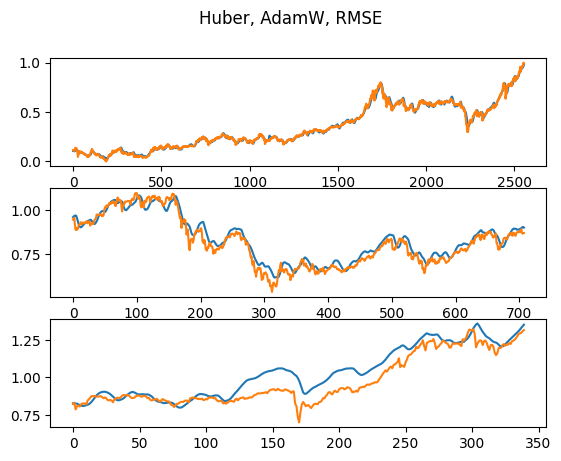

In [33]:
import matplotlib.pyplot as pyplot

fig, axs = pyplot.subplots(3)
fig.suptitle('Huber, AdamW, RMSE')
axs[0].plot(train_preds_plot['preds'])
axs[0].plot(train_preds_plot['label'])
axs[1].plot(val_preds_plot['preds'])
axs[1].plot(val_preds_plot['label'])
axs[2].plot(test_preds_plot['preds'])
axs[2].plot(test_preds_plot['label'])